In [1]:
# 导入必要的库
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, ttest_ind
import os

In [2]:
# 定义计算互信息的函数
def calculate_mutual_information(img1, img2, bins=64):
    """
    计算两幅图像之间的互信息
    """
    hgram, x_edges, y_edges = np.histogram2d(img1.ravel(), img2.ravel(), bins=bins)
    pxy = hgram / (np.sum(hgram) + 1e-10)
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    # 只计算非零部分
    non_zero = pxy > 0
    mi = np.sum(pxy[non_zero] * np.log(pxy[non_zero] / (px_py[non_zero] + 1e-10)))
    return mi

In [3]:
# 定义计算余弦相似度的函数
def cosine_sim(img1, img2):
    """
    计算两幅图像（经扁平化处理后）的余弦相似度
    """
    v1 = img1.flatten().astype(np.float32)
    v2 = img2.flatten().astype(np.float32)
    cs = cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0, 0]
    return cs

In [4]:
def align_images_euclidean(im1, im2, num_iter=500, termination_eps=1e-10):
    """
    将 im2 对齐至 im1，采用欧几里得刚性变换。
    im1: 金标准图像，BGR格式
    im2: 测试图像，BGR格式
    返回：对齐后的图像及2x3的变换矩阵
    """
    # 转换为灰度图
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    sz = im1.shape
    warp_mode = cv2.MOTION_EUCLIDEAN
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, num_iter, termination_eps)
    
    try:
        (cc, warp_matrix) = cv2.findTransformECC(im1_gray, im2_gray, warp_matrix, warp_mode, criteria)
    except cv2.error as e:
        print("对齐失败:", e)
        return None, None
    
    im_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1], sz[0]),
                                flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im_aligned, warp_matrix

In [5]:
# 定义从对齐矩阵中提取旋转角和平移距离的函数
def extract_rotation_translation(warp_matrix):
    """
    warp_matrix: 2x3 变换矩阵
    返回旋转角度（单位：度）和平移距离（像素）
    角度由 arctan(m21, m11) 得到；平移距离为 sqrt(m13^2 + m23^2)
    """
    if warp_matrix is None:
        return None, None
    angle_rad = np.arctan2(warp_matrix[1, 0], warp_matrix[0, 0])
    angle_deg = np.degrees(angle_rad)
    tx, ty = warp_matrix[0, 2], warp_matrix[1, 2]
    translation = np.sqrt(tx**2 + ty**2)
    return angle_deg, translation

In [6]:
# 加载数据集（请确保文件路径正确）
data = sio.loadmat('cw2.mat')  # 修改为你的实际数据文件路径
test_img = data['test_img']    # (20 x 10) 每个单元是一幅360x300图像
gold_img = data['gold_img']    # (1 x 10) 金标准图像，每个视图一幅图
gen_impr = data['gen_impr']    # (20 x 10) 一般印象评分（0~4），缺失值为 -1
crit_perc = data['crit_perc']  # (20 x 10) 标准评分百分比（0~100），缺失值为 -1

# 构建缺失数据掩码（评分为 -1 的为无效数据）
valid_mask = (gen_impr != -1)

每个视图的皮尔逊相关系数： [0.9273609401171707, 0.7866492556549013, 0.8167790553004866, 0.6545401107933665, 0.8698553709265843, 0.7993900235559352, 0.7964312925019911, 0.7094795776990596, 0.9268201653737713, 0.8698915780938351]
每个视图的线性回归RMSE： [0.2856813, 0.48519102, 0.43462357, 0.6218369, 0.44852054, 0.6345773, 0.7477368, 0.63066554, 0.58879113, 0.53697497]
每个视图的线性回归R2： [0.8599982961110173, 0.6188170234819088, 0.6671279852658588, 0.4284227116234207, 0.7566483786848484, 0.6390244094203263, 0.6343028143416518, 0.5033612018326405, 0.8589956140046805, 0.7567113621960565]


C:\Users\asus\AppData\Local\Temp\ipykernel_39624\1828348454.py:64: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
C:\Users\asus\AppData\Local\Temp\ipykernel_39624\1828348454.py:64: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
C:\Users\asus\AppData\Local\Temp\ipykernel_39624\1828348454.py:64: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.tight_layout()
C:\Users\asus\AppData\Local\Temp\ipykernel_39624\1828348454.py:64: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
C:\Users\asus\AppData\Local\Temp\ipykernel_39624\1828348454.py:64: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from current font.
  plt.tight_layout()
C:\Users\asus\AppData\Local\Temp\ipykernel_39624\1828348454.py:64: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing fr

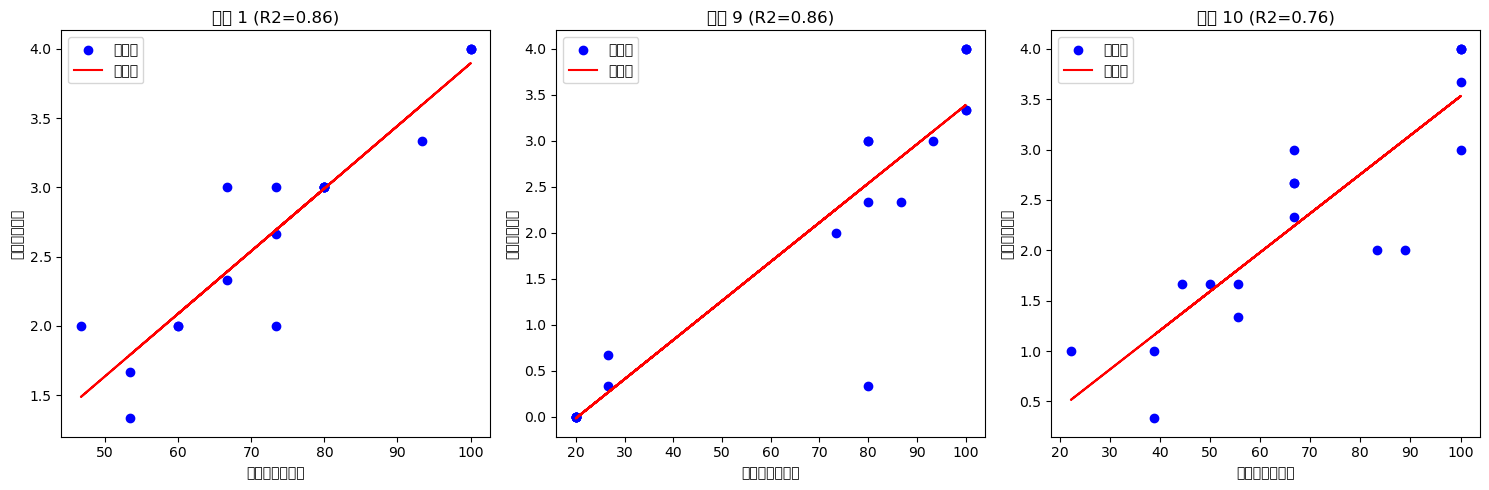

In [7]:
# ========================
# Question 1: 图像质量评分相关性与回归分析
# 对于每个视图，计算一般印象与标准百分比评分的皮尔逊相关系数，并利用线性回归
num_views = test_img.shape[1]  # 视图数（通常10个）
pearson_corrs = []
rmse_list = []
r2_list = []
model_list = []

for view in range(num_views):
    valid_idx = valid_mask[:, view]
    # 提取当前视图下所有有效评分
    gen_impr_view = gen_impr[:, view][valid_idx].astype(np.float32)
    crit_perc_view = crit_perc[:, view][valid_idx].astype(np.float32)
    
    # 计算皮尔逊相关系数
    if len(gen_impr_view) > 1:
        r, _ = pearsonr(gen_impr_view, crit_perc_view)
    else:
        r = np.nan
    pearson_corrs.append(r)
    
    # 线性回归：用 crit_perc 预测 gen_impr
    if len(gen_impr_view) > 0:
        X = crit_perc_view.reshape(-1, 1)
        y = gen_impr_view
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
        model_list.append(reg)
    else:
        rmse_list.append(np.nan)
        r2_list.append(np.nan)
        model_list.append(None)

print("每个视图的皮尔逊相关系数：", pearson_corrs)
print("每个视图的线性回归RMSE：", rmse_list)
print("每个视图的线性回归R2：", r2_list)

# 绘制R2较高的三个视图的真实值与预测值散点图
r2_array = np.array(r2_list)
best_views = np.argsort(-r2_array)[:3]

plt.figure(figsize=(15, 5))
for i, view in enumerate(best_views):
    valid_idx = valid_mask[:, view]
    gen_impr_view = gen_impr[:, view][valid_idx].astype(np.float32)
    crit_perc_view = crit_perc[:, view][valid_idx].astype(np.float32)
    X = crit_perc_view.reshape(-1, 1)
    reg = model_list[view]
    if reg is None:
        continue
    y_pred = reg.predict(X)
    plt.subplot(1, 3, i+1)
    plt.scatter(crit_perc_view, gen_impr_view, color='blue', label='真实值')
    plt.plot(crit_perc_view, y_pred, color='red', label='预测值')
    plt.title(f'视图 {view+1} (R2={r2_list[view]:.2f})')
    plt.xlabel('标准评分百分比')
    plt.ylabel('一般印象评分')
    plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# ========================
# Question 2: 测试图像与金标准图像内容相似性分析
# 对于每个视图，计算每个测试图像与对应金标准图像的结构相似性(SSI)、互信息(MI)和余弦相似度(CS)
num_participants = test_img.shape[0]
ssi_matrix = np.zeros((num_participants, num_views))
mi_matrix  = np.zeros((num_participants, num_views))
cs_matrix  = np.zeros((num_participants, num_views))

for view in range(num_views):
    # 获取金标准图像，并转换为灰度图
    gold = gold_img[0, view]
    if gold.ndim == 3:
        gold_gray = cv2.cvtColor(gold, cv2.COLOR_BGR2GRAY)
    else:
        gold_gray = gold.astype(np.uint8)
    
    for subj in range(num_participants):
        # 缺失图像则跳过（对应评分为 -1）
        if crit_perc[subj, view] == -1:
            ssi_matrix[subj, view] = np.nan
            mi_matrix[subj, view]  = np.nan
            cs_matrix[subj, view]  = np.nan
            continue
        test_im = test_img[subj, view]
        if test_im.ndim == 3:
            test_gray = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
        else:
            test_gray = test_im.astype(np.uint8)
        
        # 计算SSI
        ssi_val = ssim(gold_gray, test_gray)
        ssi_matrix[subj, view] = ssi_val
        
        # 计算互信息
        mi_val = calculate_mutual_information(gold_gray, test_gray)
        mi_matrix[subj, view] = mi_val
        
        # 计算余弦相似度
        cs_val = cosine_sim(gold_gray, test_gray)
        cs_matrix[subj, view] = cs_val

# 输出每个视图中，SSI/MI/CS最高的前3个测试图像（受试者索引）
for view in range(num_views):
    for metric, matrix, name in zip([ssi_matrix, mi_matrix, cs_matrix],
                                    [ "SSI", "MI", "CS" ],
                                    ["SSI", "MI", "CS"]):
        valid_idx = ~np.isnan(metric[:, view])
        if np.sum(valid_idx) > 0:
            sorted_idx = np.argsort(-metric[valid_idx, view])
            subj_indices = np.where(valid_idx)[0][sorted_idx[:3]]
            print(f"视图 {view+1}：{name} 最高的前3个受试者索引：", subj_indices)

# 对专家组与新手组在各相似性指标上进行统计检验
expert_idx = np.arange(0, 7)    # 专家：受试者1~7
novice_idx = np.arange(7, 20)     # 新手：受试者8~20

for view in range(num_views):
    for (matrix, label) in [(ssi_matrix, "SSI"), (mi_matrix, "MI"), (cs_matrix, "CS")]:
        data_expert = matrix[expert_idx, view][~np.isnan(matrix[expert_idx, view])]
        data_novice = matrix[novice_idx, view][~np.isnan(matrix[novice_idx, view])]
        if len(data_expert) > 0 and len(data_novice) > 0:
            t_stat, p_val = ttest_ind(data_expert, data_novice)
            print(f"视图 {view+1} {label} 专家 vs 新手：t={t_stat:.2f}, p={p_val:.3f}")

视图 1：SSI 最高的前3个受试者索引： [ 1  3 11]
视图 1：MI 最高的前3个受试者索引： [1 3 5]
视图 1：CS 最高的前3个受试者索引： [1 3 5]
视图 2：SSI 最高的前3个受试者索引： [13 18  7]
视图 2：MI 最高的前3个受试者索引： [ 2 13 18]
视图 2：CS 最高的前3个受试者索引： [13 18  5]
视图 3：SSI 最高的前3个受试者索引： [13  8 19]
视图 3：MI 最高的前3个受试者索引： [ 2  8 13]
视图 3：CS 最高的前3个受试者索引： [ 8 13 16]
视图 4：SSI 最高的前3个受试者索引： [ 1 14 13]
视图 4：MI 最高的前3个受试者索引： [1 4 2]
视图 4：CS 最高的前3个受试者索引： [1 4 2]
视图 5：SSI 最高的前3个受试者索引： [ 1 15  2]
视图 5：MI 最高的前3个受试者索引： [1 2 4]
视图 5：CS 最高的前3个受试者索引： [1 2 4]
视图 6：SSI 最高的前3个受试者索引： [ 1 18  0]
视图 6：MI 最高的前3个受试者索引： [ 1 18 11]
视图 6：CS 最高的前3个受试者索引： [ 1 18 11]
视图 7：SSI 最高的前3个受试者索引： [16  7 19]
视图 7：MI 最高的前3个受试者索引： [16  9  1]
视图 7：CS 最高的前3个受试者索引： [16  9  1]
视图 8：SSI 最高的前3个受试者索引： [1 3 5]
视图 8：MI 最高的前3个受试者索引： [ 3  1 17]
视图 8：CS 最高的前3个受试者索引： [ 3  1 17]
视图 9：SSI 最高的前3个受试者索引： [ 7  8 16]
视图 9：MI 最高的前3个受试者索引： [18  2 13]
视图 9：CS 最高的前3个受试者索引： [18  2 13]
视图 10：SSI 最高的前3个受试者索引： [ 4  1 10]
视图 10：MI 最高的前3个受试者索引： [4 1 9]
视图 10：CS 最高的前3个受试者索引： [4 1 9]
视图 1 SSI 专家 vs 新手：t=1.58, p=0.132
视图 1 MI 专家 vs 新手：t=3

In [9]:
# ========================
# Question 3: 相似性指标间的相关性和回归分析
# 示例：计算 SSI、MI、CS 三指标之间的相关系数
for view in range(num_views):
    valid = ~np.isnan(ssi_matrix[:, view]) & ~np.isnan(mi_matrix[:, view]) & ~np.isnan(cs_matrix[:, view])
    if np.sum(valid) > 1:
        r_ssi_mi, _ = pearsonr(ssi_matrix[valid, view], mi_matrix[valid, view])
        r_ssi_cs, _ = pearsonr(ssi_matrix[valid, view], cs_matrix[valid, view])
        r_mi_cs, _ = pearsonr(mi_matrix[valid, view], cs_matrix[valid, view])
        print(f"视图 {view+1} 相关系数: SSI-MI={r_ssi_mi:.2f}, SSI-CS={r_ssi_cs:.2f}, MI-CS={r_mi_cs:.2f}")

# 此处还可利用PolynomialFeatures和Ridge（或其他正则化方法）对多项式回归进行扩展，
# 并使用高斯基函数构造基函数进行线性回归，计算RMSE和R2值，
# 以及绘制表现最好的三个视图的回归曲线。

视图 1 相关系数: SSI-MI=0.75, SSI-CS=0.73, MI-CS=0.99
视图 2 相关系数: SSI-MI=0.46, SSI-CS=0.76, MI-CS=0.78
视图 3 相关系数: SSI-MI=0.32, SSI-CS=0.51, MI-CS=0.73
视图 4 相关系数: SSI-MI=0.49, SSI-CS=0.52, MI-CS=1.00
视图 5 相关系数: SSI-MI=0.72, SSI-CS=0.77, MI-CS=0.98
视图 6 相关系数: SSI-MI=0.76, SSI-CS=0.77, MI-CS=0.99
视图 7 相关系数: SSI-MI=0.49, SSI-CS=0.49, MI-CS=0.99
视图 8 相关系数: SSI-MI=0.74, SSI-CS=0.72, MI-CS=0.99
视图 9 相关系数: SSI-MI=0.01, SSI-CS=-0.07, MI-CS=0.99
视图 10 相关系数: SSI-MI=0.83, SSI-CS=0.85, MI-CS=0.99


In [10]:
# ========================
# Question 4: 图像对齐误差分析
# 对于每个测试图像与对应金标准图像，利用 ECC 算法计算刚性变换矩阵，提取旋转和平移信息
rotation_matrix = np.zeros((num_participants, num_views))
translation_matrix = np.zeros((num_participants, num_views))

for view in range(num_views):
    # 获取金标准图像并转换为 BGR 格式（若不是彩色图）
    gold = gold_img[0, view]
    if gold.ndim == 3:
        gold_bgr = gold
    else:
        gold_bgr = cv2.cvtColor(gold.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for subj in range(num_participants):
        if crit_perc[subj, view] == -1:
            rotation_matrix[subj, view] = np.nan
            translation_matrix[subj, view] = np.nan
            continue
        test_im = test_img[subj, view]
        if test_im.ndim != 3:
            test_bgr = cv2.cvtColor(test_im.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        else:
            test_bgr = test_im
        aligned_img, warp_matrix = align_images_euclidean(gold_bgr, test_bgr)
        if warp_matrix is None:
            rotation_matrix[subj, view] = np.nan
            translation_matrix[subj, view] = np.nan
        else:
            angle_deg, translation = extract_rotation_translation(warp_matrix)
            rotation_matrix[subj, view] = angle_deg
            translation_matrix[subj, view] = translation

print("旋转角度（度）：\n", rotation_matrix)
print("平移距离（像素）：\n", translation_matrix)

# 对专家组与新手组的旋转和平移值进行统计检验
for view in range(num_views):
    rot_expert = rotation_matrix[expert_idx, view][~np.isnan(rotation_matrix[expert_idx, view])]
    rot_novice = rotation_matrix[novice_idx, view][~np.isnan(rotation_matrix[novice_idx, view])]
    if len(rot_expert) > 0 and len(rot_novice) > 0:
        t_stat, p_val = ttest_ind(rot_expert, rot_novice)
        print(f"视图 {view+1} 旋转角度 专家 vs 新手：t={t_stat:.2f}, p={p_val:.3f}")
        
    trans_expert = translation_matrix[expert_idx, view][~np.isnan(translation_matrix[expert_idx, view])]
    trans_novice = translation_matrix[novice_idx, view][~np.isnan(translation_matrix[novice_idx, view])]
    if len(trans_expert) > 0 and len(trans_novice) > 0:
        t_stat, p_val = ttest_ind(trans_expert, trans_novice)
        print(f"视图 {view+1} 平移距离 专家 vs 新手：t={t_stat:.2f}, p={p_val:.3f}")

# 同时也可对旋转/平移值与评分之间进行线性回归分析（参考 Question 1 代码），计算RMSE和R2，
# 并绘制表现最佳的三个视图的回归曲线。

旋转角度（度）：
 [[-3.75624609e+00  6.95457399e-01  4.68015766e+00  4.89626551e+00
  -7.53738976e+00  1.90632272e+00 -4.19062328e+00  1.76412034e+00
   7.70642090e+00  5.70070457e+00]
 [-1.36508632e+00  4.13157582e-01 -5.04582596e+00  9.09622383e+00
   1.67580938e+00  1.13921976e+00  5.81127119e+00 -3.86422276e+00
  -5.95985711e-01 -1.21046931e-01]
 [ 2.85028368e-01  4.33852196e+00  1.27286065e+00 -1.84442558e+01
  -2.63033557e+00  1.31324872e-01  1.61782420e+00  1.98440099e+00
  -4.06159163e+00 -1.61756913e-03]
 [ 2.79431641e-01 -1.68782711e+00 -2.11265787e-01  1.65048611e+00
   4.01930475e+00  2.98473716e+00 -1.86522591e+00  8.29614067e+00
   1.33088529e+00 -3.13645840e-01]
 [-1.97404456e+00 -3.34342003e+00 -3.00894928e+00  3.06594157e+00
   1.66247177e+00 -1.46167886e+00 -2.51550508e+00 -4.23222494e+00
  -2.03873467e+00 -2.43688360e-01]
 [ 2.65067291e+00  3.08929110e+00 -8.26049805e+00 -1.09820879e+00
  -5.89713621e+00 -3.43116403e+00  3.21435380e+00  1.18487966e+00
   3.21173453e+00 -1.91